In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE, BorderlineSMOTE 

from helper_functions.classification import *
# warnings.filterwarnings("ignore")

In [25]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206', '147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36, 147.32.80.9', '147.32.87.11']

test_hosts = np.append(infected_hosts, normal_hosts)
test_hosts

array(['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
       '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207',
       '147.32.84.208', '147.32.84.209', '147.32.84.170', '147.32.84.134',
       '147.32.84.164', '147.32.87.36, 147.32.80.9', '147.32.87.11'],
      dtype='<U25')

In [10]:
data = pd.read_csv('./data/capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')
#data['Datetime'] = pd.to_datetime(data['Datetime'], infer_datetime_format=True)

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


In [11]:
data_nobground = data[ data['Label'] != 'Background']
data_nobground.shape

(645358, 13)

In [74]:
data_perhost = data_nobground.groupby(by='Src_IP_Addr').sum()
data_perhost['Dst_IPs'] = data_nobground.groupby('Src_IP_Addr')['Dst_IP_Addr'].nunique()
data_perhost['Src_Ports'] = data_nobground.groupby('Src_IP_Addr')['Src_Port'].nunique()
data_perhost['Dst_Ports'] = data_nobground.groupby('Src_IP_Addr')['Dst_Port'].nunique()
hosts = data_perhost.index
data_perhost.head()

X = data_perhost.values
labels = np.isin(data_perhost.index, infected_hosts).astype(int)
print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(522, 8)
Imbalance ratio:  0.01953125


In [76]:
data_perhost.head()

,Durat,Tos,Packets,Bytes,Flows,Dst_IPs,Src_Ports,Dst_Ports
Src_IP_Addr,,,,,,,,
10.10.20.233,50.096,0,132,8712,75,1,23,1
10.168.115.232,3.624,0,9,778,5,1,1,1
10.168.48.160,4.897,0,6,534,4,1,1,1
10.23.106.55,3.565,0,6,511,2,1,1,1
10.23.12.43,4.556,0,6,1583,4,2,2,2


In [68]:
ind = np.isin(hosts, test_hosts)
X = data_perhost[ind].values
X.shape

labels = np.isin(data_perhost[ind].index, infected_hosts)
print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(13, 5)
Imbalance ratio:  3.3333333333333335


In [38]:
num_splits = 2
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

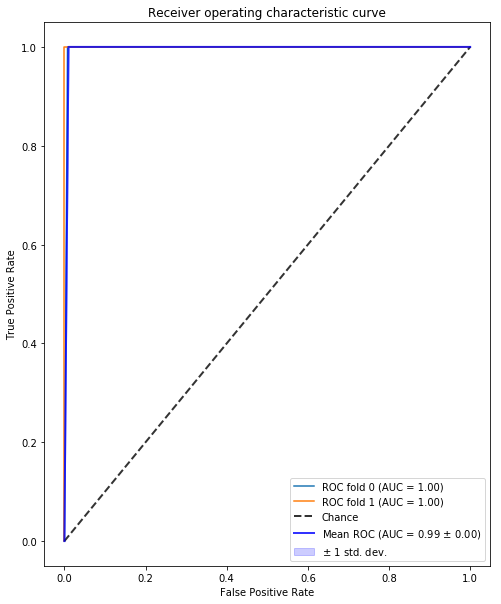

Confusion matrix, without normalization
[[510   2]
 [  0  10]]


<Figure size 432x288 with 0 Axes>

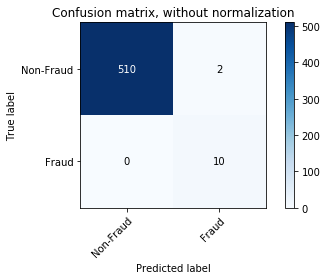

In [61]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

In [65]:
# Use cross-validation to determine the best overasmpling ratio
ratios = np.array([0.1, 0.2, 0.5, 0.8, 1])
num_neighbours = [1, 2, 3]

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)

i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, labels, clf, cv, 
                                                                                False, False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
# print("std AUC:\n", std_auc_cv)
print("Mean F1:\n", m_F1_cv)
# print("std F1:\n", std_F1_cv)

Mean AUC:
 [[0.99494949 0.99494949 0.99494949]
 [0.99494949 0.99494949 0.99494949]
 [0.99494949 0.99494949 0.99494949]
 [0.99494949 0.99494949 0.99316396]
 [0.99494949 0.99494949 0.99494949]]
Mean F1:
 [[1.         1.         0.91666667]
 [0.91666667 0.91666667 1.        ]
 [1.         0.91666667 1.        ]
 [1.         1.         0.85714286]
 [0.91666667 1.         1.        ]]


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


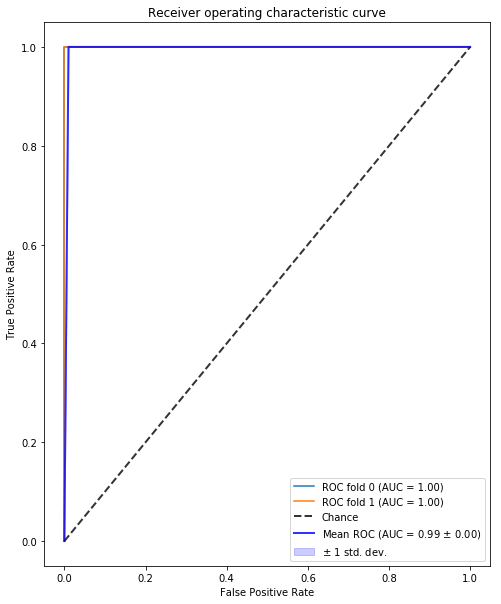

Confusion matrix, without normalization
[[ 3  0]
 [ 0 10]]


<Figure size 432x288 with 0 Axes>

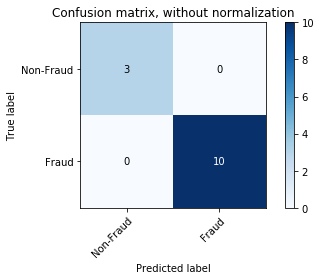

In [69]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
rf_mean_tpr, rf_std_tpr, rf_mean_auc, rf_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

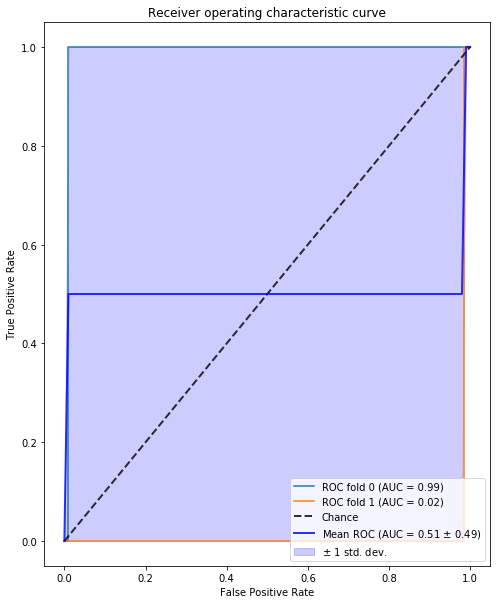

Confusion matrix, without normalization
[[500  12]
 [  5   5]]


<Figure size 432x288 with 0 Axes>

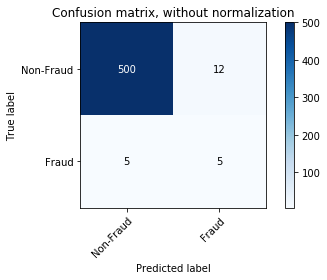

In [67]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
lr_mean_tpr, lr_std_tpr, lr_mean_auc, lr_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)